# NFL 4th-Down Win Percentage Recommendation

- Author: Marco Villagran
- Seasons: 2016-2024

In [1]:
import os, json, math
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter, MultipleLocator

import numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

import statsmodels.api as sm


COL_W, TWO_COL_W = 3.5, 7.2
WIDTH = COL_W
HEIGHT = WIDTH * 1.9

mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})
colors = {"go":"#7570b3", "fg":"#d95f02", "punt":"#1b9e77"}

DATA = "../data/processed/4thdown_labeled.csv"
RAW_PBP = "../data/raw/pbp_2016_2024.parquet"

os.makedirs("reports/figures", exist_ok=True)

df = pd.read_csv(DATA)
df_raw = pd.read_parquet(RAW_PBP)
print("Number of 4th downs", len(df))
print("Number of columns:" , len(df.columns))
print("columns: ", df.dtypes)

2025-08-10 18:27:07.222037: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 18:27:07.229053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754872027.236502  213804 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754872027.238745  213804 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754872027.245047  213804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Number of 4th downs 37335
Number of columns: 27
columns:  season                      int64
game_id                    object
play_id                     int64
quarter                     int64
game_seconds_remaining      int64
half_seconds_remaining      int64
yardline_100                int64
ydstogo                     int64
score_differential          int64
receive_2h_ko                bool
timeouts_off                int64
timeouts_def                int64
roof                       object
surface                    object
temp_f                    float64
wind_mph                  float64
spread_line               float64
wp                        float64
wp_go                     float64
wp_fg                     float64
wp_punt                   float64
dwp_go                    float64
dwp_fg                    float64
dwp_punt                  float64
p_fg_make                 float64
p_go_convert              float64
punt_net_yds              float64
dtype: object


## 01 Data Cleaning

### Data Normalization

In [2]:
# Normalize roof (open or closed)
df['roof'].value_counts(normalize=True)
df['roof'].replace({'dome':'closed', 'outdoors':'open'}, inplace=True)

# Normalize surface (grass or turf)
df['surface'] = np.where(df['surface'] == 'grass', 'grass', 'turf')

closed_mask = df['roof'].isin(['closed'])
open_mask   = ~closed_mask

### Missing values handling

In [3]:
# Cols with missing values
missing = df.isna().mean()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values (% missing):")
print((missing * 100).round(2))

Columns with missing values (% missing):
punt_net_yds    100.00
temp_f           34.34
wind_mph         34.34
wp_punt          26.04
dwp_punt         26.04
p_go_convert      0.00
dtype: float64


In [4]:
df = df.drop(columns=["punt_net_yds"])

# drop rows without target variables (WP diff)
targets = ["wp_go","wp_fg","wp_punt"]
df['wp_punt'].fillna(df['wp_punt'].min(), inplace=True)

# compute win_percentage differentials from win percentages    
df["dwp_go"]   = df["wp_go"]   - df["wp"]
df["dwp_fg"]   = df["wp_fg"]   - df["wp"]
df["dwp_punt"] = df["wp_punt"] - df["wp"]

before = len(df)
df = df.dropna(subset=targets)
print("Dropped rows with missing Win Percentages:", before - len(df))

Dropped rows with missing Win Percentages: 0


In [5]:
# Fill temp_f by roof type
avg_open_temp = df.loc[open_mask, 'temp_f'].mean()
df.loc[closed_mask, 'temp_f'] = df.loc[closed_mask, 'temp_f'].fillna(70.0)
df.loc[open_mask, 'temp_f'] = df.loc[open_mask, 'temp_f'].fillna(avg_open_temp)

# Do the same for wind_mph
avg_open_wind = df.loc[open_mask, 'wind_mph'].mean()
df.loc[closed_mask, 'wind_mph'] = df.loc[closed_mask, 'wind_mph'].fillna(0.0)
df.loc[open_mask, 'wind_mph'] = df.loc[open_mask, 'wind_mph'].fillna(avg_open_wind)

### Hygiene clips

In [6]:
# yards
df["yardline_100"] = df["yardline_100"].clip(0, 100)
df["ydstogo"] = df["ydstogo"].clip(lower=1)

# game time
df["quarter"] = df["quarter"].clip(1, 6).astype("Int64")
df["game_seconds_remaining"] = df["game_seconds_remaining"].clip(lower=0)
df["half_seconds_remaining"] = df["half_seconds_remaining"].clip(lower=0)

# game score
df["score_differential"] = df["score_differential"]
df["timeouts_off"] = df["timeouts_off"].clip(0, 3).fillna(0).astype(int)
df["timeouts_def"] = df["timeouts_def"].clip(0, 3).fillna(0).astype(int)

In [7]:
# Drop missing values (1)
before = len(df)
df = df.dropna()
print("Dropped rows with missings:", before - len(df))

Dropped rows with missings: 1


## 02 EDA

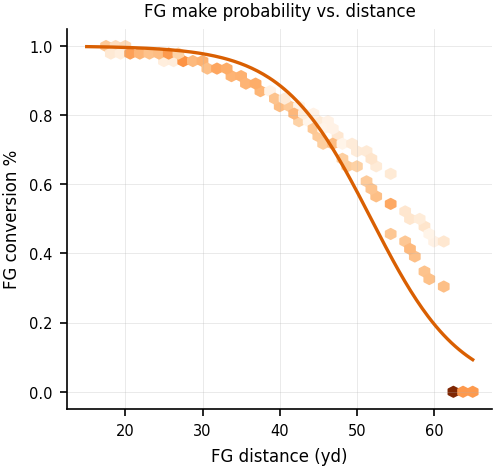

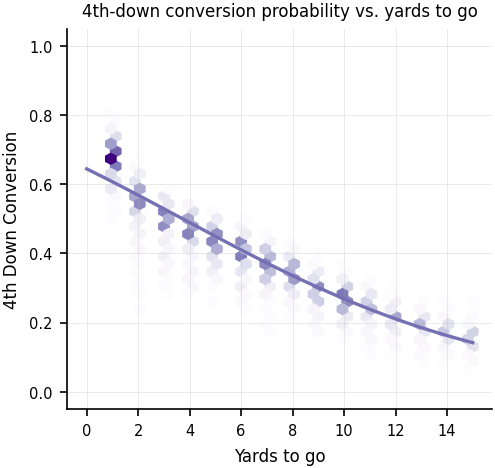

In [8]:
df["fg_dist_yd"] = df["yardline_100"] + 17

s = df.copy()

fig, ax_fg = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
ax_fg.hexbin(
    s["fg_dist_yd"], s["p_fg_make"],
    gridsize=40, cmap="Oranges",
    extent=(15, 65, 0, 1), mincnt=1
)

X_fg = sm.add_constant(s["fg_dist_yd"])
y_fg = s["p_fg_make"]
model_fg = sm.GLM(y_fg, X_fg, family=sm.families.Binomial()).fit()
x_pred_fg = np.linspace(15, 65, 200)
y_pred_fg = model_fg.predict(sm.add_constant(x_pred_fg))

ax_fg.plot(x_pred_fg, y_pred_fg, color=colors["fg"], lw=1.6)
corr_fg = np.corrcoef(s["fg_dist_yd"], s["p_fg_make"])[0, 1]

ax_fg.set_title("FG make probability vs. distance", fontsize=8)
ax_fg.set_xlabel("FG distance (yd)")
ax_fg.set_ylabel("FG conversion %")


fig.tight_layout()
fig.savefig("../reports/figures/fg_prob_vs_distance.png")
plt.show()

#  4th-down conversion probability vs. yards to go 
s = df.copy()

fig, ax_go = plt.subplots(figsize=(WIDTH, WIDTH*0.95))

ax_go.hexbin(
    s["ydstogo"], s["p_go_convert"],
    gridsize=40, cmap="Purples",
    extent=(0, 15, 0, 1), mincnt=1
)

X_go = sm.add_constant(s["ydstogo"])
y_go = s["p_go_convert"]
model_go = sm.GLM(y_go, X_go, family=sm.families.Binomial()).fit()
x_pred_go = np.linspace(0, 15, 200)
y_pred_go = model_go.predict(sm.add_constant(x_pred_go))

ax_go.plot(x_pred_go, y_pred_go, color=colors['go'], lw=1.6)
corr_go = np.corrcoef(s["ydstogo"], s["p_go_convert"])[0, 1]

ax_go.set_title("4th-down conversion probability vs. yards to go", fontsize=8)
ax_go.set_xlabel("Yards to go")
ax_go.set_ylabel("4th Down Conversion")


fig.tight_layout()
fig.savefig("../reports/figures/go_prob_vs_ytg.png")
plt.show()

Similar WP diff rate (WP differential gap < 0.5%): 0.288
go      0.423
punt    0.381
fg      0.195
Name: share, dtype: float64
teacher_best    fg    go  punt
yl_bin                        
0-20          54.3  45.7   NaN
21-40         51.5  44.3   4.2
41-60          1.7  54.9  43.3
61-80          0.0  35.1  64.9
81-100         0.0  21.9  78.0

teacher_best    fg    go  punt
ytg_bin                       
1              7.3  89.5   3.2
2             16.1  68.9  14.9
3-6           20.8  50.8  28.4
7-10          25.6  25.9  48.5
>10           22.7   7.5  69.8
Similar WP diff rate in late/close: 0.096


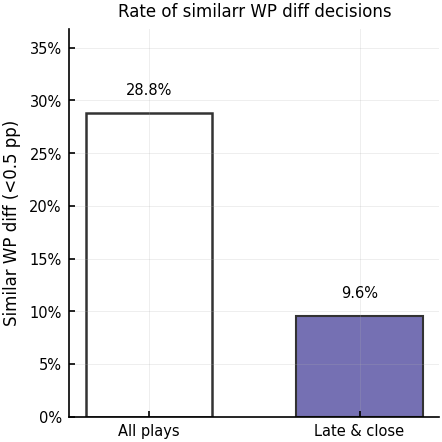

In [31]:
# Best action
dwp_mat = df[["dwp_go","dwp_fg","dwp_punt"]].to_numpy()
vals = np.where(np.isnan(dwp_mat), -np.inf, dwp_mat)
best_idx = vals.argmax(axis=1)
idx_to_name = {0:"go", 1:"fg", 2:"punt"}
df["teacher_best"] = pd.Series(best_idx, index=df.index).map(idx_to_name)

# Best margin (best - second best)
top2 = np.sort(vals, axis=1)[:, -2:]
df["best_margin"] = top2[:,1] - top2[:,0]

print("Similar WP diff rate (WP differential gap < 0.5%):", (df["best_margin"] < 0.005).mean().round(3))
print(df["teacher_best"].value_counts(normalize=True).rename("share").round(3))

#  Best action frequency with 95% CI 
labels = ["go","fg","punt"]
n = len(df)
counts = df["teacher_best"].value_counts().reindex(labels, fill_value=0).to_numpy()
props  = counts / n

def cut(x, bins, labels):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True)

df["yl_bin"]  = cut(df.yardline_100, [0,20,40,60,80,100], ["0-20","21-40","41-60","61-80","81-100"])
df["ytg_bin"] = cut(df.ydstogo, [1,2,3,6,10,50], ["1","2","3-6","7-10",">10"])

yl_share = (df.groupby("yl_bin")["teacher_best"]
              .value_counts(normalize=True)
              .rename("share").mul(100).round(1).unstack())
ytg_share = (df.groupby("ytg_bin")["teacher_best"]
              .value_counts(normalize=True)
              .rename("share").mul(100).round(1).unstack())
print(yl_share); print(); print(ytg_share)

late_close = df[(df.game_seconds_remaining < 600) & (df["score_differential"].abs() <= 8)]
print("Similar WP diff rate in late/close:", (late_close["best_margin"] < 0.005).mean().round(3))

labels = ["go","fg","punt"]
n = len(df)
counts = df["teacher_best"].value_counts().reindex(labels, fill_value=0).to_numpy()
props  = counts / n

th = 0.005
m_all = df["best_margin"].to_numpy()
m_all = m_all[np.isfinite(m_all)]
late_close = df[(df.game_seconds_remaining < 600) & (df["score_differential"].abs() <= 8)]
m_lc = late_close["best_margin"].to_numpy()
m_lc = m_lc[np.isfinite(m_lc)]

rate_all = (m_all < th).mean()
rate_lc  = (m_lc  < th).mean()

# Plot
fig, ax = plt.subplots(figsize=(WIDTH*0.9, WIDTH*0.9))

x = [0, 1]
rates = [rate_all, rate_lc]

# All plays
ax.bar(x[0], rates[0], width=0.6, facecolor="white", edgecolor="0.2", linewidth=1.2, label="All plays")
# Late & close game
ax.bar(x[1], rates[1], width=0.6, color=colors["go"], edgecolor="0.2", linewidth=1.0, label="Late & close")

for xi, val in zip(x, rates):
    ax.text(xi, val + 0.015, f"{val*100:.1f}%", ha="center", va="bottom", fontsize=7)

ax.set_xticks(x)
ax.set_xticklabels(["All plays", "Late & close"])
ax.set_ylim(0, max(rates) + 0.08)
ax.grid(alpha=0.25)
ax.set_ylabel("Similar WP diff (<0.5 pp)", fontsize=8)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
ax.tick_params(direction="in", which="both", length=3, width=0.8)
ax.set_title("Rate of similarr WP diff decisions", fontsize=8)

fig.tight_layout()
fig.savefig("../reports/figures/similar_wp_diff_barchart.png")
plt.show()


In [10]:
for col in ["roof","surface"]:
    tbl = (df.groupby(col)["teacher_best"].value_counts(normalize=True)
             .rename("share").mul(100).round(1).unstack())
    print("\n- ", col.upper()); print(tbl)


-  ROOF
teacher_best    fg    go  punt
roof                          
closed        19.7  45.6  34.7
open          19.5  41.1  39.4

-  SURFACE
teacher_best    fg    go  punt
surface                       
grass         19.4  41.2  39.4
turf          19.7  43.9  36.4


### Best decisions by field positions and yards-to-go

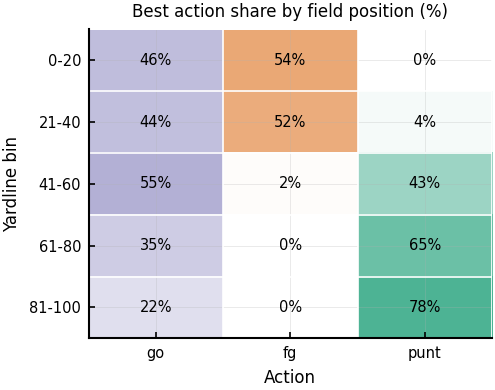

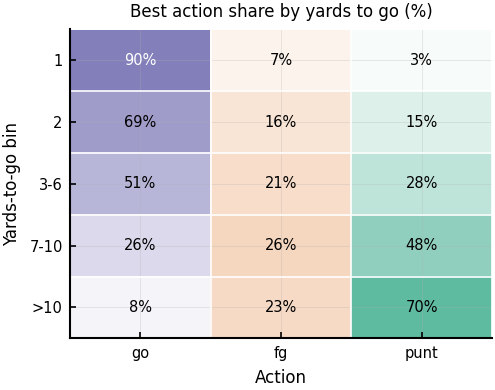

In [11]:
# field position best descision heatmap
labels = ["go","fg","punt"]
yl = yl_share[labels].fillna(0.0)
rows, cols = yl.shape
norm = (yl.to_numpy() / 100.0)

base_rgb = np.array([mcolors.to_rgb(colors[k]) for k in labels])
img = np.ones((rows, cols, 3))
for j in range(cols):
    img[:, j, :] = 1.0 - (1.0 - base_rgb[j]) * norm[:, [j]]

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.8))
ax.imshow(img, aspect="auto", interpolation="nearest")

for r in range(rows+1):
    ax.axhline(r-0.5, color="white", lw=0.8)
for c in range(cols+1):
    ax.axvline(c-0.5, color="white", lw=0.8)

ax.set_xticks(np.arange(cols))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(rows))
ax.set_yticklabels(yl.index)
ax.tick_params(direction="in", length=3, width=0.8)

for i in range(rows):
    for j in range(cols):
        v = yl.iloc[i, j]
        rgb = img[i, j, :]
        lum = 0.2126*rgb[0] + 0.7152*rgb[1] + 0.0722*rgb[2]
        ax.text(j, i, f"{v:.0f}%", ha="center", va="center",
                fontsize=7, color=("black" if lum > 0.55 else "white"))

ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.set_title("Best action share by field position (%)", fontsize=8)
ax.set_xlabel("Action")
ax.set_ylabel("Yardline bin")

fig.tight_layout()
fig.savefig("../reports/figures/best_action_by_yl_trihue_polished.png")
plt.show()

# yards to go best descision heatmap
import numpy as np, matplotlib.colors as mcolors, matplotlib.pyplot as plt

labels = ["go","fg","punt"]
yt = ytg_share[labels].fillna(0.0)  # % values
rows, cols = yt.shape
norm = (yt.to_numpy() / 100.0)

base_rgb = np.array([mcolors.to_rgb(colors[k]) for k in labels])
img = np.ones((rows, cols, 3))
for j in range(cols):
    img[:, j, :] = 1.0 - (1.0 - base_rgb[j]) * norm[:, [j]]

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.8))
ax.imshow(img, aspect="auto", interpolation="nearest")

for r in range(rows+1):
    ax.axhline(r-0.5, color="white", lw=0.8)
for c in range(cols+1):
    ax.axvline(c-0.5, color="white", lw=0.8)

ax.set_xticks(np.arange(cols))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(rows))
ax.set_yticklabels(yt.index)
ax.tick_params(direction="in", length=3, width=0.8)

for i in range(rows):
    for j in range(cols):
        v = yt.iloc[i, j]
        rgb = img[i, j, :]
        lum = 0.2126*rgb[0] + 0.7152*rgb[1] + 0.0722*rgb[2]
        ax.text(j, i, f"{v:.0f}%", ha="center", va="center",
                fontsize=7, color=("black" if lum > 0.55 else "white"))

ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.set_title("Best action share by yards to go (%)", fontsize=8)
ax.set_xlabel("Action")
ax.set_ylabel("Yards-to-go bin")

fig.tight_layout()
fig.savefig("../reports/figures/best_action_by_ytg_trihue_polished.png")
plt.show()


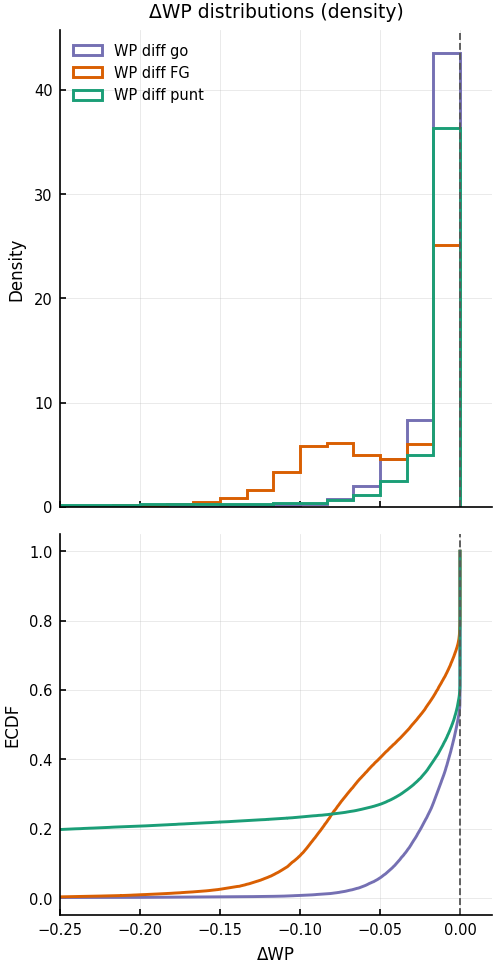

In [12]:
series = [
    np.asarray(df["dwp_go"],   float),
    np.asarray(df["dwp_fg"],   float),
    np.asarray(df["dwp_punt"], float),
]
labels = ["WP diff go", "WP diff FG", "WP diff punt"]
keys   = ["go", "fg", "punt"]  # match colors dict keys
series = [s[np.isfinite(s)] for s in series]

# shared bins
lo = min(s.min() for s in series)
hi = max(s.max() for s in series)
edges = np.linspace(lo, hi, 60 + 1)

fig, (ax_pdf, ax_ecdf) = plt.subplots(
    2, 1, figsize=(WIDTH, HEIGHT), sharex=True,
    gridspec_kw={"height_ratios": [2.0, 1.6]}
)

# density
for s, lab, key in zip(series, labels, keys):
    ax_pdf.hist(s, bins=edges, histtype="step", density=True,
                label=lab, linewidth=1.4, color=colors[key])
ax_pdf.axvline(0.0, color="0.35", linestyle="--", linewidth=0.9)
ax_pdf.set_title("ΔWP distributions (density)")
ax_pdf.set_ylabel("Density")
ax_pdf.legend(loc="upper left", frameon=False)
ax_pdf.tick_params(direction="in", which="both", length=3, width=0.8)
ax_pdf.set_xlim(-0.25, 0.02)  # zoom

# ECDF
for s, lab, key in zip(series, labels, keys):
    x = np.sort(s); F = np.arange(1, x.size + 1) / x.size
    ax_ecdf.plot(x, F, label=lab, linewidth=1.4, color=colors[key])
ax_ecdf.axvline(0.0, color="0.35", linestyle="--", linewidth=0.9)
ax_ecdf.set_xlabel("ΔWP")
ax_ecdf.set_ylabel("ECDF")
ax_ecdf.tick_params(direction="in", which="both", length=3, width=0.8)
ax_ecdf.set_xlim(-0.25, 0.02)

fig.tight_layout()
fig.savefig("../reports/figures/eda_dwp_dists_col.png")
plt.show()


In [13]:
pbp = pd.read_parquet(RAW_PBP)  # raw play-by-play
coach = pbp.loc[pbp["down"].eq(4), ["game_id","play_id","play_type"]].copy()

# Map play_type -> choice
GO_TYPES = {"run","pass","qb_kneel","qb_spike","timeout","no_play"}  # runs/passes count as "go"
def map_choice(pt):
    if pd.isna(pt): return np.nan
    pt = str(pt).lower()
    if pt == "field_goal": return "fg"
    if pt == "punt": return "punt"
    if pt in GO_TYPES: return "go"
    # Unknowns (e.g., 'fake_punt', onside kicks shouldn’t appear)
    return np.nan

coach["coach_choice"] = coach["play_type"].map(map_choice)
coach = coach.dropna(subset=["coach_choice"])

eda = df.merge(coach[["game_id","play_id","coach_choice"]], on=["game_id","play_id"], how="left")
eda["disagree"] = eda["coach_choice"].ne(eda["teacher_best"])

# Regret (teacher best ΔWP - chosen ΔWP)
def chosen_dwp(row):
    if row["coach_choice"] == "go":   return row["dwp_go"]
    if row["coach_choice"] == "fg":   return row["dwp_fg"]
    if row["coach_choice"] == "punt": return row["dwp_punt"]
    return np.nan

eda["chosen_dwp"] = eda.apply(chosen_dwp, axis=1)
eda["best_dwp"]   = eda[["dwp_go","dwp_fg","dwp_punt"]].max(axis=1)
eda["regret"]     = eda["best_dwp"] - eda["chosen_dwp"]

overall_disagree = eda["disagree"].mean()
avg_regret = eda["regret"].dropna().mean()
overall_disagree, avg_regret


(0.30902126747736647, 0.00423414813216505)

In [14]:
# Where do coaches disagree more?
regret_by_yl = eda.groupby("yl_bin")["regret"].mean().round(4)
regret_by_ytg = eda.groupby("ytg_bin")["regret"].mean().round(4)
regret_by_yl, regret_by_ytg


(yl_bin
 0-20      0.0040
 21-40     0.0046
 41-60     0.0051
 61-80     0.0037
 81-100    0.0031
 Name: regret, dtype: float64,
 ytg_bin
 1       0.0083
 2       0.0067
 3-6     0.0048
 7-10    0.0023
 >10     0.0019
 Name: regret, dtype: float64)

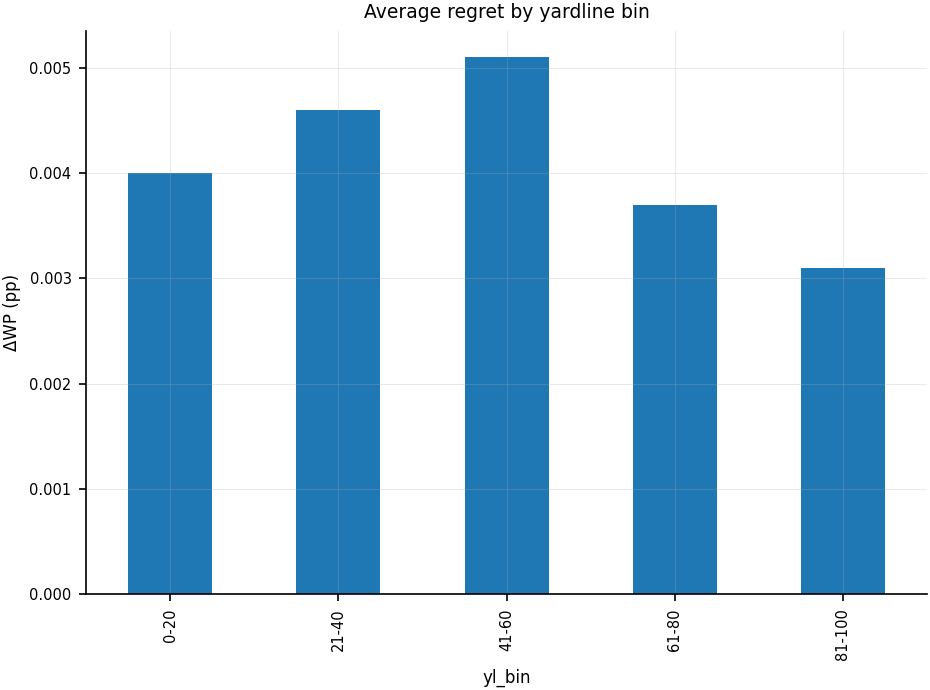

In [15]:
# Plot regret by yardline bin
fig, ax = plt.subplots()
regret_by_yl.plot(kind="bar", ax=ax)
ax.set_title("Average regret by yardline bin")
ax.set_ylabel("ΔWP (pp)")
plt.tight_layout(); plt.savefig("../reports/figures/eda_regret_by_yardline.png"); plt.show()


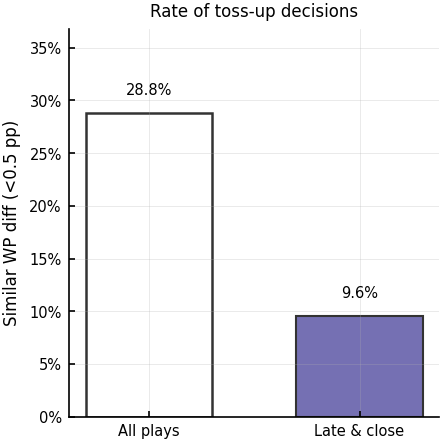

In [16]:
# Data
th = 0.005
m_all = df["best_margin"].to_numpy()
m_all = m_all[np.isfinite(m_all)]
late_close = df[(df.game_seconds_remaining < 600) & (df["score_differential"].abs() <= 8)]
m_lc = late_close["best_margin"].to_numpy()
m_lc = m_lc[np.isfinite(m_lc)]

rate_all = (m_all < th).mean()
rate_lc  = (m_lc  < th).mean()

# Plot
fig, ax = plt.subplots(figsize=(WIDTH*0.9, WIDTH*0.9))

x = [0, 1]
rates = [rate_all, rate_lc]

# All plays: white fill, border only
ax.bar(x[0], rates[0], width=0.6, facecolor="white", edgecolor="0.2", linewidth=1.2, label="All plays")
# Late & close: filled
ax.bar(x[1], rates[1], width=0.6, color=colors["go"], edgecolor="0.2", linewidth=1.0, label="Late & close")

# Annotate %
for xi, val in zip(x, rates):
    ax.text(xi, val + 0.015, f"{val*100:.1f}%", ha="center", va="bottom", fontsize=7)

# Aesthetics
ax.set_xticks(x)
ax.set_xticklabels(["All plays", "Late & close"])
ax.set_ylim(0, max(rates) + 0.08)
ax.set_ylabel("Similar WP diff (<0.5 pp)", fontsize=8)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
ax.tick_params(direction="in", which="both", length=3, width=0.8)
ax.set_title("Rate of toss-up decisions", fontsize=8)

fig.tight_layout()
fig.savefig("../reports/figures/similar_wp_diff_barchart.png")
plt.show()


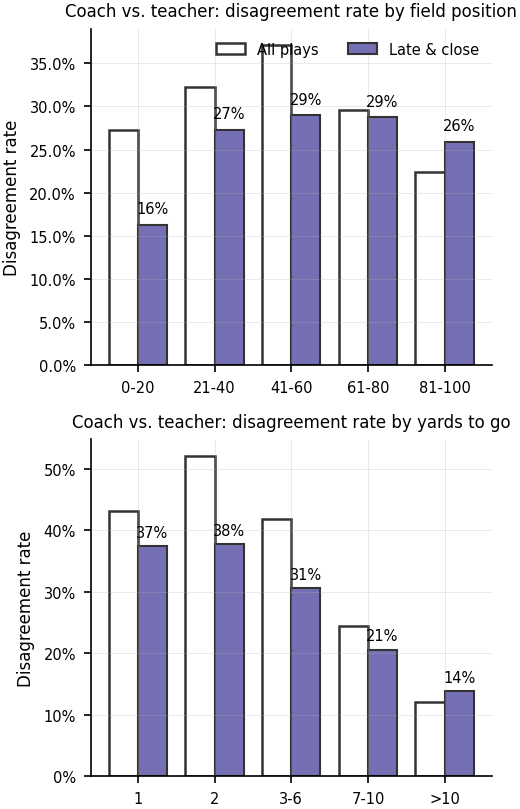

In [17]:
# bins order
yl_order = ["0-20","21-40","41-60","61-80","81-100"]
ytg_order = ["1","2","3-6","7-10",">10"]

# ensure ordered categories
eda["yl_bin"]  = pd.Categorical(eda["yl_bin"],  categories=yl_order,  ordered=True)
eda["ytg_bin"] = pd.Categorical(eda["ytg_bin"], categories=ytg_order, ordered=True)

late_close_eda = eda[(eda.game_seconds_remaining < 600) & (eda["score_differential"].abs() <= 8)]

# group means
all_yl = eda.groupby("yl_bin")["disagree"].mean().reindex(yl_order)
lc_yl  = late_close_eda.groupby("yl_bin")["disagree"].mean().reindex(yl_order)

all_ytg = eda.groupby("ytg_bin")["disagree"].mean().reindex(ytg_order)
lc_ytg  = late_close_eda.groupby("ytg_bin")["disagree"].mean().reindex(ytg_order)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(WIDTH, WIDTH*1.6), sharex=False)

# Yardline bins
x = np.arange(len(yl_order))
w = 0.38
ax1.bar(x - w/2, all_yl.values, width=w, facecolor="white", edgecolor="0.2", linewidth=1.2, label="All plays")
ax1.bar(x + w/2, lc_yl.values,  width=w, color=colors["go"], edgecolor="0.2", linewidth=1.0, label="Late & close")
for xi, v in zip(x + w/2, lc_yl.values):
    ax1.text(xi, v + 0.01, f"{v*100:.0f}%", ha="center", va="bottom", fontsize=7)
ax1.set_xticks(x, yl_order)
ax1.set_ylabel("Disagreement rate")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.set_title("Coach vs. teacher: disagreement rate by field position", fontsize=8)
ax1.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.3)
ax1.legend(frameon=False, ncols=2)

# Yards-to-go bins
x2 = np.arange(len(ytg_order))
ax2.bar(x2 - w/2, all_ytg.values, width=w, facecolor="white", edgecolor="0.2", linewidth=1.2, label="All plays")
ax2.bar(x2 + w/2, lc_ytg.values,  width=w, color=colors["go"], edgecolor="0.2", linewidth=1.0, label="Late & close")
for xi, v in zip(x2 + w/2, lc_ytg.values):
    ax2.text(xi, v + 0.01, f"{v*100:.0f}%", ha="center", va="bottom", fontsize=7)
ax2.set_xticks(x2, ytg_order)
ax2.set_ylabel("Disagreement rate")
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.set_title("Coach vs. teacher: disagreement rate by yards to go", fontsize=8)
ax2.grid(axis="y", linestyle="-", linewidth=0.4, alpha=0.3)

fig.tight_layout()
fig.savefig("../reports/figures/disagree_rate_by_bins.png")
plt.show()


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37334 entries, 0 to 37334
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   season                  37334 non-null  int64   
 1   game_id                 37334 non-null  object  
 2   play_id                 37334 non-null  int64   
 3   quarter                 37334 non-null  Int64   
 4   game_seconds_remaining  37334 non-null  int64   
 5   half_seconds_remaining  37334 non-null  int64   
 6   yardline_100            37334 non-null  int64   
 7   ydstogo                 37334 non-null  int64   
 8   score_differential      37334 non-null  int64   
 9   receive_2h_ko           37334 non-null  bool    
 10  timeouts_off            37334 non-null  int64   
 11  timeouts_def            37334 non-null  int64   
 12  roof                    37334 non-null  object  
 13  surface                 37334 non-null  object  
 14  temp_f                

## 03 Model training

In [19]:
# Split by season
train_df = df[(df["season"] >= 2016) & (df["season"] <= 2021)].copy()
val_df   = df[df["season"] == 2022].copy()
test_df  = df[df["season"].isin([2023, 2024])].copy()

print("train:", len(train_df),"val:", len(val_df),"test:", len(test_df))

train: 24307 val: 4286 test: 8741


In [20]:
for split in (train_df, val_df, test_df):
    split["in_fg_range"] = (split["fg_dist_yd"] <= 60).astype("float32")
    split["one_score"]   = (split["score_differential"].abs() <= 8).astype("float32")
    split["late_game"]   = (split["game_seconds_remaining"] < 600).astype("float32")
    split["second_half"] = (split["quarter"] > 2).astype("float32")
    split["timeouts_total"] = (split["timeouts_off"] + split["timeouts_def"]).astype("float32")
    split["timeouts_diff"]  = (split["timeouts_off"] - split["timeouts_def"]).astype("float32")

In [21]:
TARGETS = ["dwp_go","dwp_fg","dwp_punt"]

NUMERIC = [
    "quarter","game_seconds_remaining","half_seconds_remaining",
    "yardline_100","ydstogo","score_differential",
    "timeouts_off","timeouts_def","timeouts_total","timeouts_diff",
    "temp_f","wind_mph","spread_line","receive_2h_ko",
    "fg_dist_yd","in_fg_range","one_score","late_game","second_half",
]
CATEG_STR = ["roof","surface"]

# Casts
for c in NUMERIC:
    for split in (train_df, val_df, test_df):
        split[c] = pd.to_numeric(split[c], errors="coerce").astype("float32")
for c in CATEG_STR:
    for split in (train_df, val_df, test_df):
        split[c] = split[c].astype(str)


In [22]:
norm = layers.Normalization(axis=-1)
norm.adapt(train_df[NUMERIC].to_numpy().astype("float32"))

roof_lookup = layers.StringLookup(output_mode="one_hot"); roof_lookup.adapt(train_df["roof"])
surface_lookup = layers.StringLookup(output_mode="one_hot"); surface_lookup.adapt(train_df["surface"])

def build_preprocessor():
    inputs = {c: keras.Input(name=c, shape=(), dtype=tf.float32) for c in NUMERIC}
    inputs.update({c: keras.Input(name=c, shape=(), dtype=tf.string) for c in CATEG_STR})
    num_cols = [layers.Reshape((1,), name=f"reshape_{c}")(inputs[c]) for c in NUMERIC]
    x_num = norm(layers.Concatenate(name="concat_nums")(num_cols))
    x = layers.Concatenate(name="feat_concat")([x_num, roof_lookup(inputs["roof"]), surface_lookup(inputs["surface"])])
    return keras.Model(inputs, x, name="preprocessor")

preproc = build_preprocessor()


I0000 00:00:1754872031.964016  213804 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [23]:
def df_to_dataset(frame: pd.DataFrame, shuffle=False, batch_size=256):
    X = {c: frame[c].values.astype("float32") for c in NUMERIC}
    X.update({c: frame[c].values.astype(str) for c in CATEG_STR})
    y = {
        "dwp":    frame[TARGETS].astype("float32").values,     # (n,3)
        "aux_fg": frame[["p_fg_make"]].astype("float32").values,     # (n,1)
        "aux_go": frame[["p_go_convert"]].astype("float32").values,  # (n,1)
    }
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(frame), seed=123)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

batch_size = 256
train_ds = df_to_dataset(train_df, shuffle=True,  batch_size=batch_size)
val_ds   = df_to_dataset(val_df,   shuffle=False, batch_size=batch_size)
test_ds  = df_to_dataset(test_df,  shuffle=False, batch_size=batch_size)


In [24]:
def build_mlp(hidden=[256, 128, 64, 32], dropout=0.1, l2=1e-5):
    inputs = {c: keras.Input(name=c, shape=(), dtype=tf.float32) for c in NUMERIC}
    inputs.update({c: keras.Input(name=c, shape=(), dtype=tf.string) for c in CATEG_STR})

    z = preproc(inputs)
    for h in hidden:
        z = layers.Dense(h, activation="gelu",
                         kernel_regularizer=keras.regularizers.l2(l2))(z)
        z = layers.BatchNormalization()(z)
        z = layers.Dropout(dropout)(z)

    dwp_out = layers.Dense(3, name="dwp")(z)                # main head
    aux_fg  = layers.Dense(1, activation="sigmoid", name="aux_fg")(z)
    aux_go  = layers.Dense(1, activation="sigmoid", name="aux_go")(z)

    return keras.Model(inputs=inputs, outputs={"dwp": dwp_out, "aux_fg": aux_fg, "aux_go": aux_go},
                       name="mlp_dwp_plus_aux")

model = build_mlp(dropout=0.12)
model.summary()


Model: "mlp_dwp_plus_aux"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fg_dist_yd          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ game_seconds_remai… │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ half_seconds_remai… │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_fg_range         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ late_game           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_score           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quarter             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ receive_2h_ko       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roof (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_differential  │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_half         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spread_line         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ surface             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temp_f (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timeouts_def        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timeouts_diff       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timeouts_off        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 52,012 (203.18 KB)

 Trainable params: 51,013 (199.27 KB)

 Non-trainable params: 999 (3.91 KB)

In [25]:
def policy_agreement(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float32)
    )

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss={"dwp": keras.losses.Huber(delta=0.01), "aux_fg": "mse", "aux_go": "mse"},
    loss_weights={"dwp": 1.0, "aux_fg": 0.2, "aux_go": 0.2},
    metrics={"dwp": [keras.metrics.MeanAbsoluteError(name="mae"), policy_agreement]},
)

cb = [
    keras.callbacks.EarlyStopping(
        monitor="val_dwp_mae",
        mode="min",
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_dwp_mae",
        mode="min",
        factor=0.5,
        patience=9,
        min_lr=1e-5
    ),
    
    keras.callbacks.ModelCheckpoint(
        "../models/mlp_dwp_plus_aux_best.keras",
        monitor="val_dwp_mae",
        mode="min",
        save_best_only=True
    ),
]


history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=cb, verbose=1)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - aux_fg_loss: 0.0293 - aux_go_loss: 0.0356 - dwp_loss: 0.0061 - dwp_mae: 0.6160 - dwp_policy_agreement: 0.4176 - loss: 0.0225 - val_aux_fg_loss: 0.0535 - val_aux_go_loss: 0.0148 - val_dwp_loss: 0.0012 - val_dwp_mae: 0.1199 - val_dwp_policy_agreement: 0.3825 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - aux_fg_loss: 0.0091 - aux_go_loss: 0.0121 - dwp_loss: 0.0031 - dwp_mae: 0.3123 - dwp_policy_agreement: 0.4086 - loss: 0.0107 - val_aux_fg_loss: 0.0345 - val_aux_go_loss: 0.0081 - val_dwp_loss: 9.4372e-04 - val_dwp_mae: 0.0991 - val_dwp_policy_agreement: 0.4760 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - aux_fg_loss: 0.0074 - aux_go_loss: 0.0084 - dwp_loss: 0.0020 - dwp_mae: 0.2099 - dwp_policy_agreement: 0.4404 - loss: 0.0084 - val_aux_fg_loss: 0.0148 - val_aux_go_loss: 0.0047 - val_dwp_loss: 6.5708e-04 - val_dwp_mae: 0.0705 - val_dw

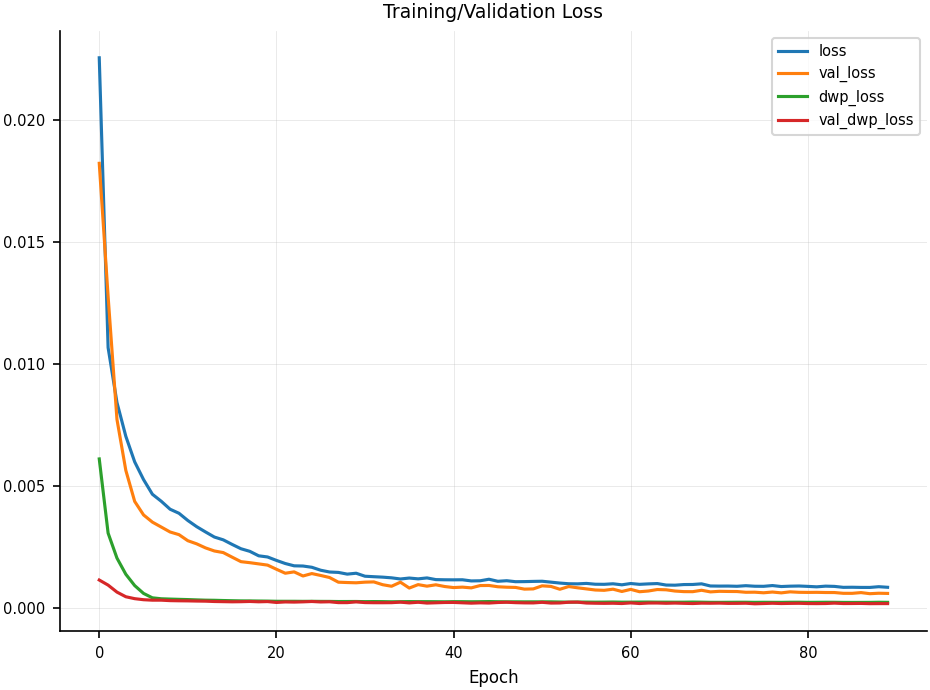

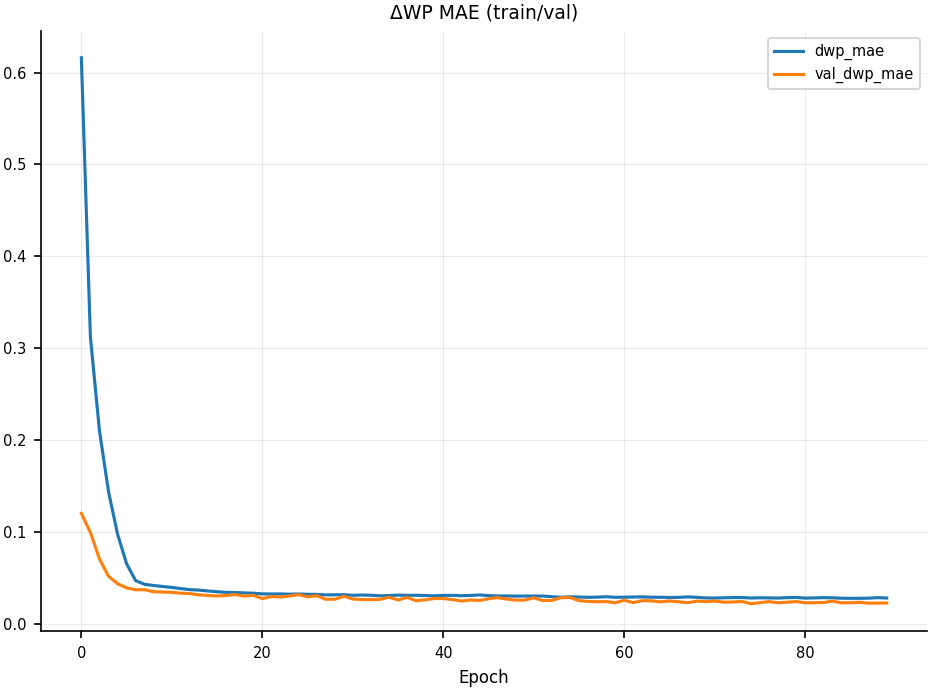

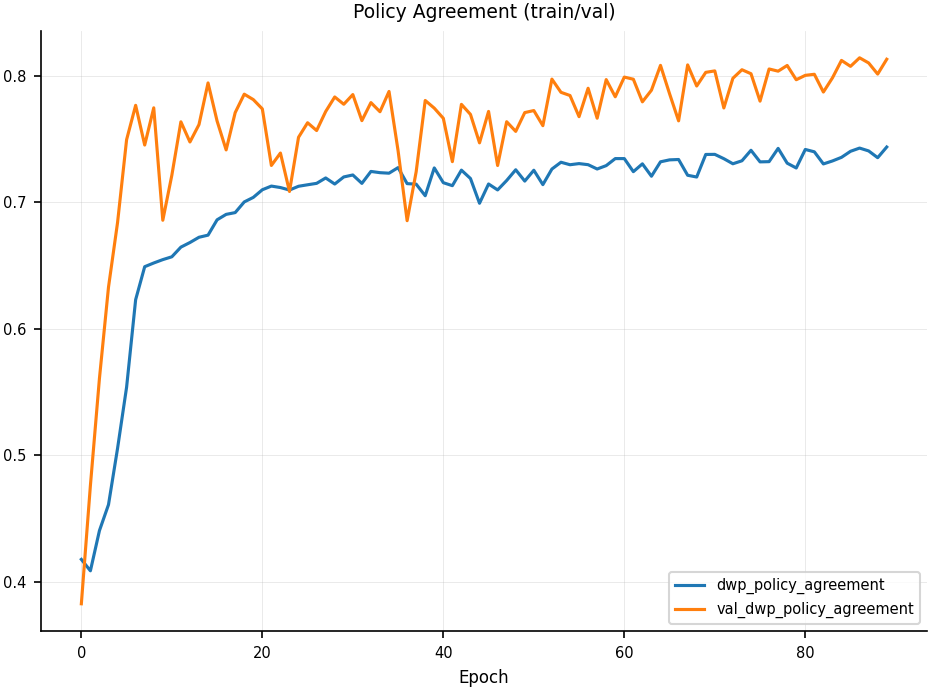

In [26]:
# 7) Training curves (loss & key metrics)
hist = pd.DataFrame(history.history)

def plot_history(keys, title, fname):
    fig, ax = plt.subplots()
    for k in keys:
        if k in hist.columns:
            ax.plot(hist[k], label=k)
    ax.set_xlabel("Epoch"); ax.set_title(title); ax.legend()
    fig.tight_layout(); fig.savefig(f"reports/figures/{fname}"); plt.show()

# total and main-head loss
plot_history(["loss","val_loss","dwp_loss","val_dwp_loss"], "Training/Validation Loss", "loss_curves.png")
# main-head MAE
plot_history(["dwp_mae","val_dwp_mae"], "ΔWP MAE (train/val)", "mae_curves.png")
# main-head policy agreement (if tracked)
plot_history(["dwp_policy_agreement","val_dwp_policy_agreement"], "Policy Agreement (train/val)", "policy_curves.png")

Policy agreement (test): 0.794
Mean regret (ΔWP, test): 0.0023

Per-yardline bin metrics:
            n  policy_agreement  mean_regret
yl_bin                                     
0-20    1489            0.7388       0.0041
21-40   1756            0.7511       0.0033
41-60   2149            0.7780       0.0020
61-80   2657            0.8483       0.0013
81-100   690            0.8594       0.0006

Per-ydstogo bin metrics:
             n  policy_agreement  mean_regret
ytg_bin                                     
1        1678            0.8844       0.0012
2         680            0.7029       0.0033
3-6      1961            0.6838       0.0039
7-10     2227            0.7638       0.0028
>10      2195            0.8811       0.0009

Confusion matrix (rows = teacher, cols = model):
 pred_best       go    fg  punt
teacher_best                  
go            2554   449   577
fg             338  1440    37
punt           330    72  2944

Row-normalized confusion:
 pred_best        go     f

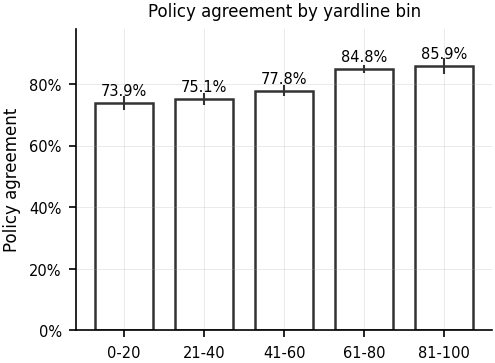

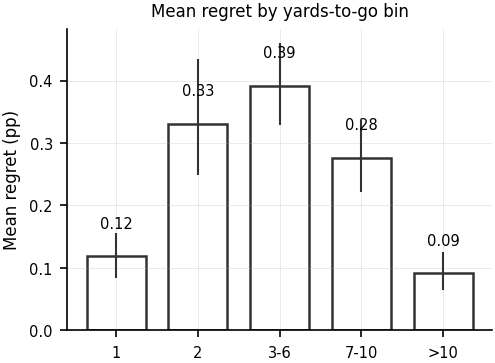

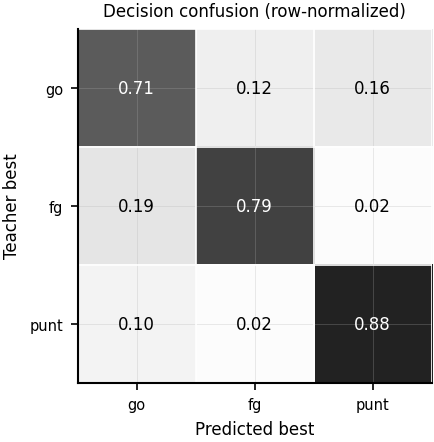

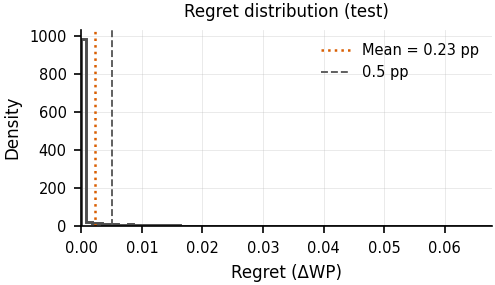

In [27]:
# 1) Predictions (main head)
pred = model.predict(test_ds, verbose=0)
pred_main = pred["dwp"] if isinstance(pred, dict) else pred  # just in case

# 2) Build aligned eval frame
test_eval = test_df.reset_index(drop=True).copy()
true_mat = test_eval[["dwp_go","dwp_fg","dwp_punt"]].to_numpy()
pred_mat = pred_main

idx2name = np.array(["go","fg","punt"])
true_best_idx = true_mat.argmax(axis=1)
pred_best_idx = pred_mat.argmax(axis=1)

test_eval["teacher_best"] = idx2name[true_best_idx]
test_eval["pred_best"]    = idx2name[pred_best_idx]
test_eval["true_best_dwp"] = true_mat.max(axis=1)
test_eval["chosen_true_dwp"] = true_mat[np.arange(len(true_mat)), pred_best_idx]
test_eval["regret"] = test_eval["true_best_dwp"] - test_eval["chosen_true_dwp"]

policy = (test_eval["pred_best"] == test_eval["teacher_best"]).mean()
true_best = test_eval["true_best_dwp"].values
chosen_dwp = test_eval["chosen_true_dwp"].values
regret = (true_best - chosen_dwp).mean()

print("Policy agreement (test):", round(float(policy), 3))
print("Mean regret (ΔWP, test):", round(float(regret), 4))

# 3) Ensure bins exist (or remake them)
def cut(x, bins, labels):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True)

if "yl_bin" not in test_eval.columns:
    test_eval["yl_bin"] = cut(test_eval.yardline_100, [0,20,40,60,80,100], ["0-20","21-40","41-60","61-80","81-100"])
if "ytg_bin" not in test_eval.columns:
    test_eval["ytg_bin"] = cut(test_eval.ydstogo, [1,2,3,6,10,50], ["1","2","3-6","7-10",">10"])

# 4) Per-bin metrics
def bin_metrics(df, bin_col):
    g = df.groupby(bin_col, observed=True)
    n = g.size().rename("n")
    pa = g.apply(lambda x: (x["pred_best"] == x["teacher_best"]).mean()).rename("policy_agreement")
    mr = g["regret"].mean().rename("mean_regret")
    return pd.concat([n, pa, mr], axis=1)

yl_metrics  = bin_metrics(test_eval, "yl_bin")
ytg_metrics = bin_metrics(test_eval, "ytg_bin")
print("\nPer-yardline bin metrics:\n", yl_metrics.round(4))
print("\nPer-ydstogo bin metrics:\n", ytg_metrics.round(4))

# 5) Confusion matrix (teacher vs model best)
labels = ["go","fg","punt"]
cm = pd.crosstab(test_eval["teacher_best"], test_eval["pred_best"], dropna=False).reindex(index=labels, columns=labels, fill_value=0)
cm_norm_rows = cm.div(cm.sum(axis=1).replace(0,1), axis=0).round(3)
print("\nConfusion matrix (rows = teacher, cols = model):\n", cm)
print("\nRow-normalized confusion:\n", cm_norm_rows)

# 6) Plots
# 6a) Policy agreement by yardline bin
yl_order = ["0-20","21-40","41-60","61-80","81-100"]
yl_metrics = yl_metrics.reindex(yl_order)

# bootstrap CI for proportions
B = 2000
rng = np.random.default_rng(42)
vals = (test_eval.assign(bin=test_eval["yl_bin"])
        .dropna(subset=["bin"]) [["bin","pred_best","teacher_best"]].to_numpy())
ci_lo, ci_hi = [], []
for b in yl_order:
    idx = (vals[:,0] == b)
    z = (vals[idx,1] == vals[idx,2]).astype(float)
    if z.size == 0:
        ci_lo.append(np.nan); ci_hi.append(np.nan); continue
    boots = z[rng.integers(0, z.size, size=(B, z.size))].mean(axis=1)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    ci_lo.append(lo); ci_hi.append(hi)

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.75))
x = np.arange(len(yl_order))
y = yl_metrics["policy_agreement"].to_numpy()
ax.bar(x, y, width=0.72, facecolor="white", edgecolor="0.2", linewidth=1.2)
ax.vlines(x, ci_lo, ci_hi, colors="0.2", linewidth=1.0)
for xi, v in zip(x, y):
    ax.text(xi, v + 0.015, f"{v*100:.1f}%", ha="center", va="bottom", fontsize=7)
ax.set_xticks(x, yl_order)
ax.set_ylim(0, min(1.0, y.max() + 0.12))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Policy agreement")
ax.set_title("Policy agreement by yardline bin", fontsize=8)
ax.grid(axis="y", linewidth=0.4, alpha=0.3)
fig.tight_layout(); fig.savefig("reports/figures/policy_by_yardline_polished.png"); plt.show()

# 6b) Mean regret by ydstogo bin
# ordered bins
ytg_order = ["1","2","3-6","7-10",">10"]
ytg_metrics = ytg_metrics.reindex(ytg_order)

# bootstrap CI for mean
B = 2000
rng = np.random.default_rng(43)
ci_lo, ci_hi = [], []
for b in ytg_order:
    z = test_eval.loc[test_eval["ytg_bin"]==b, "regret"].dropna().to_numpy()
    if z.size == 0:
        ci_lo.append(np.nan); ci_hi.append(np.nan); continue
    boots = z[rng.integers(0, z.size, size=(B, z.size))].mean(axis=1)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    ci_lo.append(lo*100); ci_hi.append(hi*100)

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.75))
x = np.arange(len(ytg_order))
y = (ytg_metrics["mean_regret"]*100).to_numpy()
ax.bar(x, y, width=0.72, facecolor="white", edgecolor="0.2", linewidth=1.2)
ax.vlines(x, ci_lo, ci_hi, colors="0.2", linewidth=1.0)
for xi, v in zip(x, y):
    ax.text(xi, v + 0.04, f"{v:.2f}", ha="center", va="bottom", fontsize=7)
ax.set_xticks(x, ytg_order)
ax.set_ylabel("Mean regret (pp)")
ax.set_title("Mean regret by yards-to-go bin", fontsize=8)
ax.grid(axis="y", linewidth=0.4, alpha=0.3)
fig.tight_layout(); fig.savefig("reports/figures/regret_by_ydstogo_polished.png"); plt.show()


# 6c) Confusion heatmap (simple imshow)
labels = ["go","fg","punt"]
A = cm_norm_rows.reindex(index=labels, columns=labels).to_numpy()
fig, ax = plt.subplots(figsize=(WIDTH*0.9, WIDTH*0.9))
im = ax.imshow(A, vmin=0, vmax=1, cmap="Greys", aspect="equal", interpolation="nearest")
ax.set_xticks(range(3)); ax.set_yticks(range(3))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
for i in range(3):
    for j in range(3):
        ax.text(j, i, f"{A[i,j]:.2f}", ha="center", va="center",
                fontsize=8, color=("black" if A[i,j] < 0.6 else "white"))
# subtle grid + left/bottom borders
for k in range(4):
    ax.axhline(k-0.5, color="white", lw=0.8)
    ax.axvline(k-0.5, color="white", lw=0.8)
ax.spines["left"].set_visible(True);  ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_linewidth(1.0); ax.spines["bottom"].set_linewidth(1.0)
ax.set_xlabel("Predicted best"); ax.set_ylabel("Teacher best")
ax.set_title("Decision confusion (row-normalized)", fontsize=8)
fig.tight_layout(); fig.savefig("reports/figures/confusion_heatmap_polished.png"); plt.show()


# 6d) Regret distribution (histogram)
z = test_eval["regret"].dropna().to_numpy()
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.6))
edges = np.linspace(0, np.percentile(z, 99.5), 80)
ax.hist(z, bins=edges, histtype="step", density=True, linewidth=1.4, color="0.3")
ax.axvline(z.mean(), color=colors["fg"], lw=1.2, ls=":", label=f"Mean = {z.mean()*100:.2f} pp")
ax.axvline(0.005, color="0.35", lw=0.9, ls="--", label="0.5 pp")
ax.set_xlim(0, max(0.03, edges.max()))
ax.set_xlabel("Regret (ΔWP)"); ax.set_ylabel("Density")
ax.set_title("Regret distribution (test)", fontsize=8)
ax.legend(frameon=False, fontsize=7, loc="upper right")
fig.tight_layout(); fig.savefig("reports/figures/regret_hist_polished.png"); plt.show()


In [28]:
# Define Late & Close
lc_mask = (test_eval["game_seconds_remaining"] < 600) & (test_eval["score_differential"].abs() <= 8)
te_all = test_eval
te_lc  = test_eval.loc[lc_mask].copy()

# Overall
policy_all  = (te_all["pred_best"] == te_all["teacher_best"]).mean()
regret_all  = te_all["regret"].mean()
policy_lc   = (te_lc["pred_best"] == te_lc["teacher_best"]).mean()
regret_lc   = te_lc["regret"].mean()

print(f"[ALL] Policy agreement: {policy_all:.3f} | Mean regret: {regret_all:.4f}")
print(f"[L&C] Policy agreement: {policy_lc:.3f} | Mean regret: {regret_lc:.4f}")


[ALL] Policy agreement: 0.794 | Mean regret: 0.0023
[L&C] Policy agreement: 0.744 | Mean regret: 0.0099


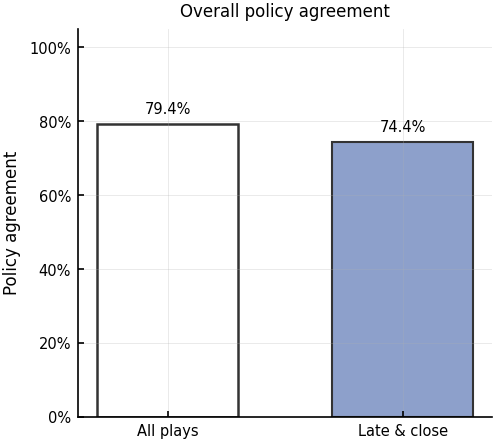

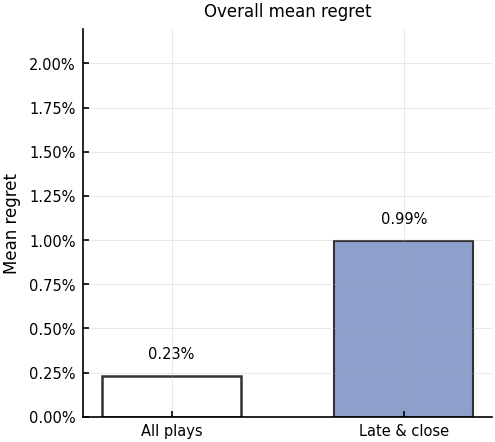

In [30]:
# values
pa_all, pa_lc = policy_all, policy_lc
rg_all, rg_lc = regret_all*100, regret_lc*100  # pp


x = [0, 1]

# --- Policy agreement (%)
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.9))
ax.bar(x[0], policy_all, width=0.6, facecolor="white", edgecolor="0.2", linewidth=1.2)
ax.bar(x[1], policy_lc, width=0.6, color="#8da0cb", edgecolor="0.2", linewidth=1.0)
for xi, v in zip(x, [policy_all, policy_lc]):
    ax.text(xi, v + 0.02, f"{v*100:.1f}%", ha="center", va="bottom", fontsize=7)
ax.set_xticks(x, ["All plays", "Late & close"])
ax.set_ylabel("Policy agreement")
ax.set_title("Overall policy agreement", fontsize=8)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(0, 1.05)
ax.tick_params(direction="in", length=3, width=0.8)
ax.grid(axis="y", linewidth=0.4, alpha=0.3)
fig.tight_layout()
fig.savefig("reports/figures/overall_policy_agreement.png")
plt.show()

# --- Mean regret (%)
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.9))
ax.bar(x[0], regret_all, width=0.6, facecolor="white", edgecolor="0.2", linewidth=1.2)
ax.bar(x[1], regret_lc, width=0.6, color="#8da0cb", edgecolor="0.2", linewidth=1.0)
for xi, v in zip(x, [regret_all, regret_lc]):
    ax.text(xi, v + 0.0008, f"{v*100:.2f}%", ha="center", va="bottom", fontsize=7)
ax.set_xticks(x, ["All plays", "Late & close"])
ax.set_ylabel("Mean regret")
ax.set_title("Overall mean regret", fontsize=8)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(0, max(regret_all, regret_lc) + 0.012)
ax.tick_params(direction="in", length=3, width=0.8)
ax.grid(axis="y", linewidth=0.4, alpha=0.3)
fig.tight_layout()
fig.savefig("reports/figures/overall_mean_regret.png")
plt.show()
